In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install mahotas

import os  # для работы с файловой системой
import numpy as np  # для работы с массивами
import pandas as pd  # для анализа данных
from PIL import Image  # для обработки изображений
from sklearn.decomposition import PCA  # для анализа главных компонент
from sklearn.cluster import KMeans  # для кластеризации
from sklearn.metrics import silhouette_score  # для оценки кластеров
import matplotlib.pyplot as plt  # для визуализации данных
import seaborn as sns  # для создания стильных графиков

# Библиотека для текстурных признаков
import mahotas as mh  # для извлечения текстурных признаков


In [15]:
# Параметры данных
data_dir = "/content/drive/MyDrive/IBCh/LIveMIELmiiish2/single_nuclei_images/19_10_2024AIRE1_sorting"  # путь к данным
days = ["0 day", "1 day", "4 day"]  # названия папок с изображениями
image_size = (128, 128)  # размер изображений для обработки текстурных признаков

# Загрузка изображений и меток
def load_images_and_labels(data_dir, days):
  images = []  # список для хранения изображений
  labels = []  # список для хранения меток
  for label, day in enumerate(days):  # проходим по папкам с изображениями
    folder_path = os.path.join(data_dir, day)  # полный путь к текущей папке
    for file_name in os.listdir(folder_path):  # проходим по файлам в папке
      file_path = os.path.join(folder_path, file_name)  # полный путь к файлу
      try:
        image = Image.open(file_path).convert("L")  # открываем изображение и конвертируем в оттенки серого
        image = image.resize(image_size)  # изменяем размер изображения
        images.append(np.array(image))  # добавляем изображение в список
        labels.append(label)  # добавляем метку в список (0, 1 или 2)
      except Exception as e:  # обрабатываем ошибки при загрузке изображения
        print(f"Ошибка с файлом {file_path}: {e}")  # выводим сообщение об ошибке
  return images, np.array(labels)  # возвращаем список изображений и меток

# Загружаем изображения
images, labels = load_images_and_labels(data_dir, days)  # вызываем функцию загрузки
print(f"Загружено {len(images)} изображений.")  # выводим количество загруженных изображений


Загружено 989 изображений.


In [16]:
# Функция для извлечения текстурных, хроматиновых признаков, моментов Цернике и центра масс
import mahotas as mh
import numpy as np
from skimage.measure import moments, moments_central, moments_normalized, moments_hu


def extract_features(images):
  """
  Извлечение различных признаков из изображений, включая Haralick, TAS, хроматиновые признаки, моменты Цернике и центр масс.

  images: list - список изображений в формате numpy (оттенки серого).

  return: np.ndarray - матрица признаков (N, D), где N - число изображений.
  """
  features = []  # список для хранения признаков

  for image in images:  # проходим по изображениям
    # Haralick features
    haralick_features = mh.features.haralick(image).mean(axis=0)  # вычисляем Haralick признаки и усредняем

    # TAS features (Tamura)
    coarseness = np.std(image)  # грубость (пример через стандартное отклонение)
    contrast = (np.max(image) - np.min(image)) / (np.max(image) + np.min(image) + 1e-5)  # контраст
    directionality = np.var(np.gradient(image)[0]) + np.var(np.gradient(image)[1])  # направленность

    tas_features = np.array([coarseness, contrast, directionality])

    # Chromatin features
    mean_intensity = np.mean(image)  # средняя интенсивность
    intensity_variance = np.var(image)  # дисперсия интенсивности
    energy = np.sum(image**2) / image.size  # энергия (нормированная)

    chromatin_features = np.array([mean_intensity, intensity_variance, energy])

    # Zernike moments
    zernike_moments = mh.features.zernike_moments(image, radius=min(image.shape) // 2)  # вычисляем моменты Цернике

    # Center of mass
    total_intensity = np.sum(image)  # суммарная интенсивность
    y, x = np.indices(image.shape)  # индексы пикселей
    center_of_mass_y = np.sum(y * image) / (total_intensity + 1e-5)  # центр масс по Y
    center_of_mass_x = np.sum(x * image) / (total_intensity + 1e-5)  # центр масс по X

    center_of_mass = np.array([center_of_mass_x, center_of_mass_y])

    # Собираем все признаки в один вектор
    combined_features = np.hstack([
      haralick_features, tas_features, chromatin_features, zernike_moments, center_of_mass
    ])
    features.append(combined_features)  # добавляем признаки в список

  return np.array(features)  # возвращаем массив признаков

# Извлекаем признаки
features = extract_features(images)  # вызываем функцию извлечения признаков
print(f"Извлечено признаков: {features.shape}")  # выводим размеры матрицы признаков


Извлечено признаков: (989, 46)


In [ ]:
features

array([[7.42743012e-02, 4.38201158e+00, 9.70473904e-01, ...,
        2.40165683e-03, 6.36568695e+01, 6.19763921e+01],
       [1.17193567e-01, 5.33674411e+00, 9.85711949e-01, ...,
        3.04488735e-02, 6.56297210e+01, 6.48757212e+01],
       [5.84340525e-02, 5.48719165e+00, 9.88959817e-01, ...,
        1.73452338e-03, 6.48002153e+01, 6.36487280e+01],
       ...,
       [4.35555796e-02, 2.60958934e+00, 9.93433766e-01, ...,
        6.49965866e-03, 6.09183659e+01, 6.39570375e+01],
       [4.66616904e-02, 3.05580653e+00, 9.95794479e-01, ...,
        8.51351909e-03, 6.74820423e+01, 6.14267125e+01],
       [9.11079454e-02, 3.75466430e+00, 9.94098758e-01, ...,
        1.19148020e-02, 5.97418189e+01, 6.61429617e+01]])

PCA завершено. Объяснённая дисперсия: 99.99%
Размеры после PCA: (97, 2)


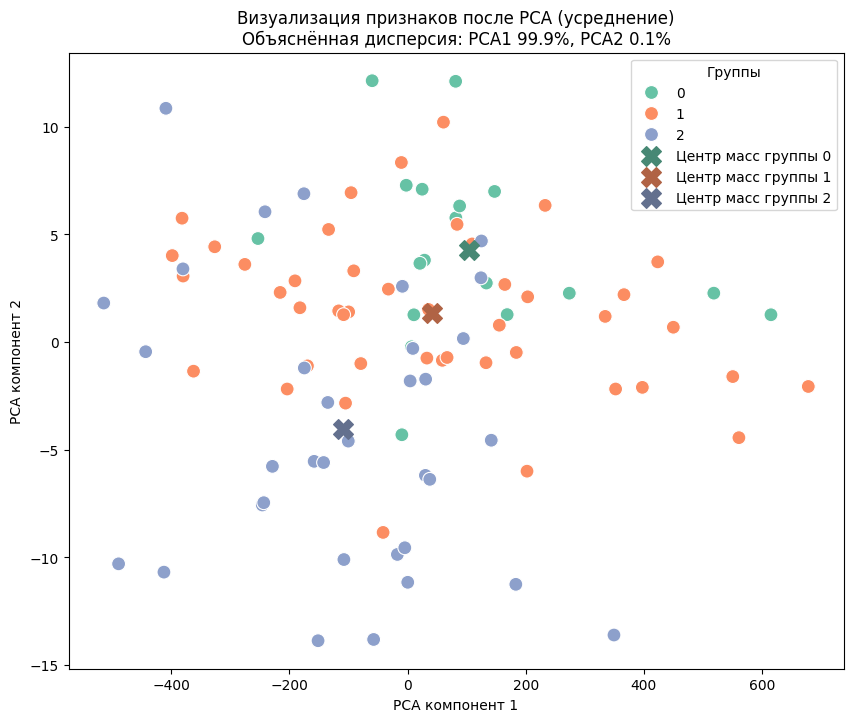

In [19]:
# Анализ с использованием PCA
import numpy as np

def average_features(features, labels, group_size=10):
  """
  Усреднение признаков по указанному количеству ядер для каждой группы.

  features: np.ndarray - матрица признаков (N, D), где N - число изображений.
  labels: np.ndarray - метки групп (N,).
  group_size: int - количество ядер для усреднения.

  return: np.ndarray, np.ndarray - усреднённые признаки и соответствующие метки.
  """
  averaged_features = []  # список для хранения усреднённых признаков
  averaged_labels = []  # список для хранения меток усреднённых групп
  for group in np.unique(labels):  # проходим по каждой группе
    group_features = features[labels == group]  # выделяем признаки текущей группы
    for i in range(0, len(group_features), group_size):  # разбиваем на подгруппы
      subset = group_features[i:i + group_size]  # берем подгруппу из group_size элементов
      if len(subset) == group_size:  # проверяем, что подгруппа полная
        averaged_features.append(subset.mean(axis=0))  # усредняем признаки в подгруппе
        averaged_labels.append(group)  # сохраняем метку группы
  return np.array(averaged_features), np.array(averaged_labels)

# Усредняем признаки
averaged_features, averaged_labels = average_features(features, labels)  # вызываем функцию усреднения

# Применяем PCA
def apply_pca(features, n_components=2):
  pca = PCA(n_components=n_components)  # создаем объект PCA с двумя компонентами
  reduced_features = pca.fit_transform(features)  # выполняем преобразование признаков
  explained_variance_ratio = pca.explained_variance_ratio_ * 100  # вычисляем объясненную дисперсию в процентах
  print(f"PCA завершено. Объяснённая дисперсия: {explained_variance_ratio.sum():.2f}%")  # выводим объясненную дисперсию
  return reduced_features, explained_variance_ratio  # возвращаем преобразованные признаки и объяснённую дисперсию

reduced_features, explained_variance_ratio = apply_pca(averaged_features)  # вызываем функцию PCA
print(f"Размеры после PCA: {reduced_features.shape}")  # выводим размеры преобразованных признаков

# Вычисление центров масс
centers_of_mass = []  # список для хранения центров масс
for group in np.unique(averaged_labels):  # проходим по каждой группе
  group_features = reduced_features[averaged_labels == group]  # выделяем признаки текущей группы
  center = group_features.mean(axis=0)  # вычисляем центр масс группы
  centers_of_mass.append(center)  # добавляем центр в список
centers_of_mass = np.array(centers_of_mass)  # преобразуем в массив

# Визуализация PCA с центрами масс
plt.figure(figsize=(10, 8))  # задаем размеры графика
palette = sns.color_palette("Set2", len(np.unique(averaged_labels)))  # создаем палитру цветов для групп
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=averaged_labels, palette=palette, s=100)  # создаем график точек
for i, center in enumerate(centers_of_mass):  # добавляем центры масс на график
  darker_color = tuple([c * 0.7 for c in palette[i]])  # делаем цвет центра масс темнее
  plt.scatter(center[0], center[1], color=darker_color, marker="X", s=200, label=f"Центр масс группы {i}")  # добавляем центр масс

# Добавляем объяснённую дисперсию на график
plt.title(f"Визуализация признаков после PCA (усреднение)\nОбъяснённая дисперсия: PCA1 {explained_variance_ratio[0]:.1f}%, PCA2 {explained_variance_ratio[1]:.1f}%")  # заголовок графика с дисперсией
plt.xlabel("PCA компонент 1")  # метка оси X
plt.ylabel("PCA компонент 2")  # метка оси Y
plt.legend(title="Группы")  # добавляем легенду
plt.show()  # отображаем график
